In [1]:
%cd /content

/content


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

## DeepConvNet with ReLU Activation Function

In [3]:
class DeepConvNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(DeepConvNet_ReLU, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1,5),bias=False),
            nn.Conv2d(25, 25, kernel_size=(2,1),bias=False),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Conv2d(25, 50, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Conv2d(50, 100, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Conv2d(100, 200, kernel_size=(1,5),bias=False),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),

            nn.Flatten(),
            nn.Linear(46200,n_output,bias=True)
        )

    def forward(self, x):
        out = self.model(x)
        return out

## Data Preparation

In [4]:
def data_prep(X,y,sub_sample,average,noise,time):
    total_X = None
    total_y = None

    # Trim the data from 1000 to 500 time steps
    X = X[:,:,0:time]
    #print('Shape after trimm:',X.shape)

    # Maxpool the data from 1000 to 500/subsample
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    #print('Shape after maxpool:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape after averaging+noise and concatenating:',total_X.shape)

    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    #print('Shape after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def test_data_prep(X, y, time):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:time]
    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)

    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)

    return total_X, total_y

In [5]:
def load_data(time, debug=False, onehot=True):

## Loading the dataset
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769


    ## Random splitting and reshaping the data
    # First generating the training and validation indices using random splitting

    ind_valid = np.random.choice(2115, 375, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


    ## Preprocessing the dataset
    x_train,y_train = data_prep(x_train,y_train,2,2,True,time)
    x_valid,y_valid = data_prep(x_valid,y_valid,2,2,True,time)
    X_test,y_test = test_data_prep(X_test,y_test, time)

    if debug:
        print('Shape of training set:',x_train.shape)
        print('Shape of validation set:',x_valid.shape)
        print('Shape of training labels:',y_train.shape)
        print('Shape of validation labels:',y_valid.shape)
        print('Shape of testing set:',X_test.shape)
        print('Shape of testing labels:',y_test.shape)


    if onehot:
        # Converting the labels to categorical variables for multiclass classification
        y_train = to_categorical(y_train, 4)
        y_valid = to_categorical(y_valid, 4)
        y_test = to_categorical(y_test, 4)
        if debug:
            print('Shape of training labels after categorical conversion:',y_train.shape)
            print('Shape of validation labels after categorical conversion:',y_valid.shape)
            print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    if debug:
        print('Shape of training set after adding width info:',x_train.shape)
        print('Shape of validation set after adding width info:',x_valid.shape)
        print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 2,3)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 2,3)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 2,3)
    if debug:
        print('Shape of training set after dimension reshaping:',x_train.shape)
        print('Shape of validation set after dimension reshaping:',x_valid.shape)
        print('Shape of test set after dimension reshaping:',x_test.shape)

    return x_train, x_valid, x_test, y_train, y_valid, y_test, person_train_valid, person_test

## Setting Model Parameters

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
epochs = 20
lr = 1e-5

model = DeepConvNet_ReLU(n_output=4)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)
early_stopper = EarlyStopper(patience=3, min_delta=10)

DeepConvNet_ReLU(
  (model): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), bias=False)
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1), bias=False)
    (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=F

In [8]:
def testing(test_loader, model, device):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        model.cuda(0)
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            n = targets.shape[0]
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
            valid_loss_history.append(train_loss)
            correct_test = (torch.max(outputs,1)[1]==targets).sum().item()
        test_accuracy = correct_test/n
        valid_loss /= len(valid_loader)
            # print("testing accuracy:",correct/n)
    return test_accuracy, valid_loss

## Training

In [9]:
time = 500
min_loss=1
max_accuracy = 0
x_train, x_valid, x_test, y_train, y_valid, y_test, person_train_valid, person_test = load_data(time=time, debug = True, onehot=False)
device = torch.device("cuda:0")

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).long()
x_valid_tensor = torch.tensor(x_valid).float()
y_valid_tensor = torch.tensor(y_valid).long()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test).long()

# Create PyTorch datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define batch size and create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.cuda(0)
summary(model.cuda(),(1,22,250))

loss_history = []
train_accuracy_history = []
valid_accuracy_history = []
valid_loss_history = []

# Train the model
for epoch in range(epochs):
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%1==0:
        n = targets.shape[0]
        correct = (torch.max(outputs,1)[1]==targets).sum().item()
        train_accuracy = correct / n
        train_accuracy_history.append(train_accuracy)

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            model.cuda(0)
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                n = targets.shape[0]
                outputs = model(inputs)
                vloss = criterion(outputs, targets)
                valid_loss += vloss.item()
                if early_stopper.early_stop(valid_loss):
                  break

        correct_test = (torch.max(outputs,1)[1]==targets).sum().item()
        valid_accuracy = correct_test/n
        valid_accuracy_history.append(valid_accuracy)

        valid_loss /= len(valid_loader)
        train_loss /= len(train_loader)
        loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        print("epochs:",epoch,"Training loss:",train_loss,"Training Accuracy:",train_accuracy,"Validation Accuracy:",valid_accuracy,"Validation Loss:",valid_loss,"Learning rate:",scheduler.get_last_lr()[0])

        if valid_loss<min_loss:
            min_loss = valid_loss

        if valid_accuracy>max_accuracy:
            max_accuracy = train_accuracy


print("Maximum Valid Accuracy:", max_accuracy, "Minimum Valid Loss:", min_loss)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (443, 22, 250)
Shape of testing labels: (443,)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (443, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 1, 22, 250)
Shape of validation set after dimension reshaping: (1500, 1, 22, 250)
Shape of test set after dimension reshaping: (443, 1, 22, 250)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 25, 22, 246]             125
            Conv2d-2          [-1, 25, 21, 246]           1,250
       BatchNorm2d-3          [-1, 25, 21, 246]              50
              ReLU-4          [-1, 25, 21, 246]               0


## Plot Graphs of Accuracy and Loss

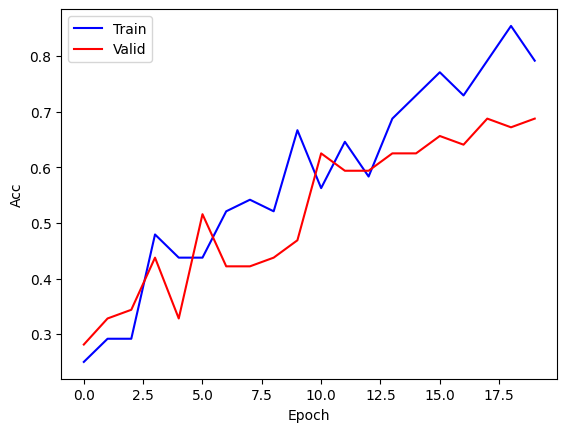

In [10]:
plt.plot(range(epochs), train_accuracy_history, 'b-', label='Train')
plt.plot(range(epochs), valid_accuracy_history, 'r-', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

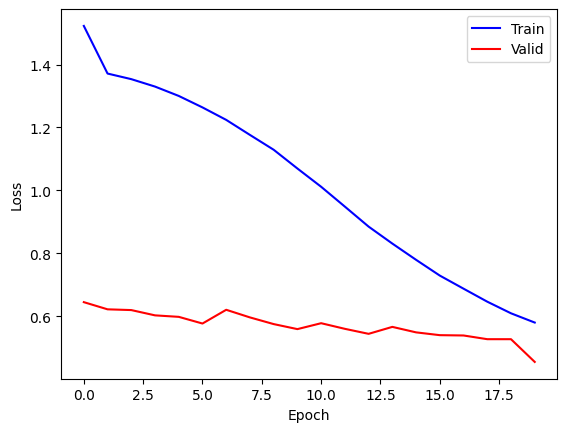

In [11]:
plt.plot(range(epochs), loss_history, 'b-', label='Train')
plt.plot(range(epochs), valid_loss_history, 'r-', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [12]:
## Testing the DeepConvNet model with all subjects

test_acc, test_loss = testing(test_loader, model, device)
print('Test accuracy of the DeepConvNet model:', test_acc)

Test accuracy of the DeepConvNet model: 0.711864406779661


In [13]:
def test_single(x_test, y_test, model, person_test, batch_size, sub_idx=None, time_period=1000):
    X_test_cur = x_test[:, :, :time_period]
    y_test_cur = y_test

    if sub_idx is not None:
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    test_single_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_cur).float(), torch.tensor(y_test_cur).long())
    test_single_loader = torch.utils.data.DataLoader(test_single_dataset, batch_size=batch_size)

    model.eval()
    valid_single_loss = 0
    with torch.no_grad():
        model.cuda(0)
        for inputs, targets in test_single_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            n = targets.shape[0]
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_single_loss += loss.item()
            valid_loss_history.append(valid_single_loss)
            correct_test = (torch.max(outputs,1)[1]==targets).sum().item()
        test_single_accuracy = correct_test/n
        valid_single_loss /= len(valid_loader)
            # print("testing accuracy:",correct/n)
    return test_single_accuracy, valid_loss


In [14]:
## Testing the DeepConvNet model on Subject 0

test_single_acc, test_single_loss = test_single(x_test, y_test, model, person_test, batch_size=128, sub_idx=0)
print('Test accuracy of the DeepConvNet model on Subject 0:', test_single_acc)

Test accuracy of the DeepConvNet model on Subject 0: 0.42


In [15]:
def data_prep(X,y):

    total_X = None
    total_y = None

    # Noise
    X_average = X + np.random.normal(0.0, 0.5, X.shape)

    total_X =  X_average
    total_y =  y

    print('Shape of X after noise:',total_X.shape)

    return total_X,total_y

In [16]:
def load_data_time_bin(time, debug=True, onehot=False, time_bin=True):

## Loading the dataset
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769

    print(X_train_valid.shape)
    print(y_train_valid.shape)
    print(X_test.shape)
    print(y_test.shape)
    print (person_train_valid.shape)
    print (person_test.shape)

    ## Preprocessing dataset
    if time_bin:
      X_train_valid,y_train_valid = data_prep(X_train_valid,y_train_valid)

    if debug:
        print('Shape of training/validation set:',X_train_valid.shape)
        print('Shape of training/validation labels:',y_train_valid.shape)
        print('Shape of testing set:',X_test.shape)
        print('Shape of testing labels:',y_test.shape)


    if onehot:
        # Converting the labels to categorical variables for multiclass classification
        y_train_valid = to_categorical(y_train_valid, 4)
        y_test = to_categorical(y_test, 4)
        if debug:
            print('Shape of training/valid labels after categorical conversion:',y_train_valid.shape)
            print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1)
    x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    if debug:
        print('Shape of training set after adding width info:',X_train_valid.shape)
        print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 2,3)
    X_train_valid = np.swapaxes(X_train_valid, 1,3)
    X_train_valid = np.swapaxes(X_train_valid, 2,3)

    if debug:
        print('Shape of training/validation set after dimension reshaping:',X_train_valid.shape)
        print('Shape of test set after dimension reshaping:',x_test.shape)

    return X_train_valid, y_train_valid, x_test, y_test

In [17]:
time = 1000
## Preprocessing the dataset

x_train_valid, y_train_valid, x_test, y_test = load_data_time_bin(time=time, onehot=False, time_bin=True)

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
(2115, 1)
(443, 1)
Shape of X after noise: (2115, 22, 1000)
Shape of training/validation set: (2115, 22, 1000)
Shape of training/validation labels: (2115,)
Shape of testing set: (443, 22, 1000)
Shape of testing labels: (443,)
Shape of training set after adding width info: (2115, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training/validation set after dimension reshaping: (2115, 1, 22, 1000)
Shape of test set after dimension reshaping: (443, 1, 22, 1000)


In [18]:
def get_model(time, n_output):
    if time == 250:
      units = 480
    elif time == 500:
      units = 1120
    elif time == 750:
      units = 1800
    elif time == 1000:
      units = 2480
    print("Units:", units)
    class ShallowConvNet(nn.Module):
        def __init__(self, time, n_output):
            super(ShallowConvNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 40, kernel_size=(1, 10))
            self.conv2 = nn.Conv2d(40, 40, kernel_size=(22, 1))
            self.batchnorm = nn.BatchNorm2d(40)
            self.activation = nn.ReLU()
            self.avgpool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))
            self.dropout = nn.Dropout(0.4)
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(units, n_output)

        def forward(self, x):
            x = self.activation(self.batchnorm(self.conv1(x)))
            x = self.activation(self.batchnorm(self.conv2(x)))
            x = self.avgpool(x)
            x = torch.log(torch.clamp(x, min=1e-06))
            x = self.flatten(x)
            x = self.dropout(x)
            x = self.fc(x)
            return x

    return ShallowConvNet(time, n_output)

In [19]:
epochs = 50
lr = 1e-3

new_model = get_model(time, n_output = 4)
new_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=lr)
#optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.6)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5], gamma=0.1)
early_stopper = EarlyStopper(patience=3, min_delta=10)

Units: 2480


In [20]:
def train(time_period):
  min_loss=1
  max_accuracy = 0
  max_train_valid_accuracy = 0

  X_train_valid_cur = x_train_valid[:, :, :, :time_period]
  y_train_valid_cur = y_train_valid
  X_test_cur = x_test[:, :, :, :time_period]
  y_test_cur = y_test
  print(X_train_valid_cur.shape)

  # Convert numpy arrays to PyTorch tensors
  x_train_valid_tensor = torch.tensor(X_train_valid_cur).float()
  y_train_valid_tensor = torch.tensor(y_train_valid_cur).long()
  x_test_tensor = torch.tensor(X_test_cur).float()
  y_test_tensor = torch.tensor(y_test_cur).long()

  # Create PyTorch datasets
  train_valid_dataset = TensorDataset(x_train_valid_tensor, y_train_valid_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Define batch size and create data loaders
  batch_size = 128
  train_valid_loader = DataLoader(train_valid_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  new_model = get_model(time_period, n_output = 4)
  summary(new_model.cuda(),(1,22,time_period))

  loss_history = []
  train_valid_accuracy_history = []
  test_accuracy_history = []
  test_loss_history = []

  # Train the model
  for epoch in range(epochs):
      train_valid_loss = 0
      for inputs, targets in train_valid_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = new_model(inputs)
          loss = new_criterion(outputs, targets)
          train_valid_loss += loss.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      if epoch%1==0:
          n = targets.shape[0]
          correct = (torch.max(outputs,1)[1]==targets).sum().item()
          train_valid_accuracy = correct / n
          train_valid_accuracy_history.append(train_accuracy)

          model.eval()
          test_loss = 0
          with torch.no_grad():
              model.cuda(0)
              for inputs, targets in test_loader:
                  inputs, targets = inputs.to(device), targets.to(device)
                  n = targets.shape[0]
                  outputs = new_model(inputs)
                  vloss = criterion(outputs, targets)
                  test_loss += vloss.item()
                  if early_stopper.early_stop(test_loss):
                    break

          correct_test = (torch.max(outputs,1)[1]==targets).sum().item()
          test_accuracy = correct_test/n
          test_accuracy_history.append(test_accuracy)

          test_loss /= len(test_loader)
          train_valid_loss /= len(train_valid_loader)
          loss_history.append(train_valid_loss)
          test_loss_history.append(test_loss)

          print("epochs:",epoch,"Training/Validation loss:",train_valid_loss,"Training/Validation Accuracy:",train_valid_accuracy,"Test Accuracy:",test_accuracy,"Test Loss:",test_loss,"Learning rate:",scheduler.get_last_lr()[0])

          if test_loss<min_loss:
              min_loss = test_loss

          if test_accuracy>max_accuracy:
              max_accuracy = test_accuracy

          if train_valid_accuracy>max_train_valid_accuracy:
              max_train_valid_accuracy = train_valid_accuracy

  print("Time:", str(time), "Maximum Test Accuracy:", max_accuracy, "Minimum Valid Loss:", min_loss)

  return max_train_valid_accuracy, max_accuracy

250
(2115, 1, 22, 250)
Units: 480
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 40, 22, 241]             440
       BatchNorm2d-2          [-1, 40, 22, 241]              80
              ReLU-3          [-1, 40, 22, 241]               0
            Conv2d-4           [-1, 40, 1, 241]          35,240
       BatchNorm2d-5           [-1, 40, 1, 241]              80
              ReLU-6           [-1, 40, 1, 241]               0
         AvgPool2d-7            [-1, 40, 1, 12]               0
           Flatten-8                  [-1, 480]               0
           Dropout-9                  [-1, 480]               0
           Linear-10                    [-1, 4]           1,924
Total params: 37,764
Trainable params: 37,764
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 5.09
Pa

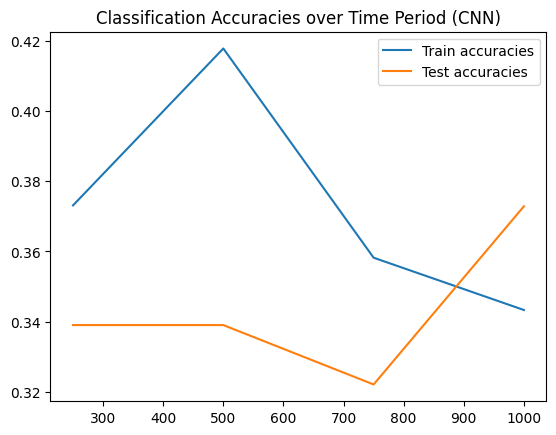

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_scores = []
test_scores = []

for time in range(250, 1001, 250):
    print(str(time))
    train_valid_accuracy, test_accuracy = train(time_period=time)
    train_scores.append(train_valid_accuracy)
    test_scores.append(test_accuracy)


print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." % max(test_scores))
print("The corresponding time period is %d." % (250 + 250 * max_idx))

# plot
plt.plot(range(250, 1001, 250), train_scores, label='Train accuracies')
plt.plot(range(250, 1001, 250), test_scores, label='Test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()









